# Match Plans - The Cold Start Problem

## Table of Contents
1. [Introduction](#Introduction)
2. [Data Collection](#Data-Collection)
3. [Neural Network Explanation & Results](#Neural-Network-Explanation-&-Results)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Naive Initial Model Selection](#Naive-Model-Selection)
6. [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
7. [Feature Engineering](#Feature-Engineering)
8. [Model Selection](#Model-Selection)
9. [Model Training](#Model-Training)
10. [Model Evaluation](#Model-Evaluation)
11. [Conclusion and Future Work](#Conclusion-and-Future-Work)
12. [References](#References)

## Introduction

#### *Problem Description*
In ROME (Renewal Optimization Engine), a fascet of the 'cold start problem' for small groups in california is that we receive a medical plan (characterized by plan_admin_name in the universal file type schema) and in order to complete current total cost, we must match those plans (via carrier name, plan name, network, issuer codes, and cost sharing details) to plans in the Ideon dataset available in the clients zip code. As of now, this manual matching process is a roadblock to potentially automating the configuration steps in ROME. A client may have anywhere from one plan to 12 plans, depending on the carrier/s and their decisions.

#### *Objective*
The objective of this project is to automate the matching process by developing a machine learning model that can accurately link a given medical plan name from a clients census to the correct plan in the ideon dataset. This is a data linkeage problem.

#### *Proposed Solution*
Levergaing the renewal workbooks already matched plans across clients, build a dataset that enables a machine learning algorithm to learn how to predict the correct ideon plan name given the census plan name. The target variable in this dataset will be a binary variable indicating a match (1 to represent positive) or not a match (0 to represent a negative).

In [1]:
# import statements
import pandas as pd
import numpy as np
import random
import time
from tqdm import tqdm
from google.cloud import bigquery
import matplotlib.pyplot as plt

# Set options to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

## Data Collection

* For each client that has gone through the workbook, we have already gotten their plans and then matched those plans with the plans from the Ideon dataset. This has been done manually.
* Because we have already matched, we can go through each workbook and collect that information. We've made a google sheet with this info and we can download it as an `actuals.csv`
* For each client, we want to go get all the available plans, create a dataframe, match only the matched plans in a dataset, and then keep doing that for all clients.
* After (or maybe during) we then need to create the false match case, where we still need to store all of the plans for a given client and then create a false match in the dataset.
* For each plan should we have every plan being a false match? How should we create the dataset?

In [8]:
# Reading in small group plans actuals to begin to build dataset
small_group_actuals_file_path = '~/match-plans/data/actuals.csv'
small_group_actuals_df = pd.read_csv(small_group_actuals_file_path)
small_group_actuals_df['plan_effective_start_date'] = pd.to_datetime(small_group_actuals_df['plan_effective_start_date'])
small_group_actuals_df.rename(columns={'plan_id':'id','carrier_name':'census_carrier_name'},inplace=True)

# prep the data to be able to query and iterate through
grouped = small_group_actuals_df.groupby(['client_name', 'zip_code', 'plan_effective_start_date'])

# Initialize list to store client objects
clients = []

# Loop through each group
for (client_name, zip_code, start_date), group in grouped:
    client = {}
    client['client_name'] = client_name
    client['zip_code'] = zip_code
    client['plan_effective_start_date'] = start_date

    # Extract year and quarter
    year = start_date.year
    quarter = (start_date.month - 1) // 3 + 1
    
    client['year'] = year
    client['quarter'] = f'Q{quarter}'
    client['plans'] = group.drop(columns=['client_name', 'zip_code', 'plan_effective_start_date']).to_dict(orient='records')
    clients.append(client)

# verify that we were able to get the information by printing 0th index
print(clients[0])

{'client_name': 'Aya Living', 'zip_code': 92108, 'plan_effective_start_date': Timestamp('2023-01-01 00:00:00'), 'year': 2023, 'quarter': 'Q1', 'plans': [{'census_carrier_name': 'California Choice', 'plan_admin_name': '2023 Sharp Gold HMO A', 'id': '92499CA0000003-77'}, {'census_carrier_name': 'California Choice', 'plan_admin_name': '2023 Kaiser Permanente Bronze HMO B', 'id': '40513CA0000004-77'}, {'census_carrier_name': 'California Choice', 'plan_admin_name': '2023 Kaiser Permanente Silver HMO A', 'id': '40513CA0000002-77'}, {'census_carrier_name': 'California Choice', 'plan_admin_name': '2023 Anthem Blue Cross Gold PPO E', 'id': '27603CA0000018-77'}, {'census_carrier_name': 'California Choice', 'plan_admin_name': '2023 Sharp Silver HMO B', 'id': '92499CA0000006-77'}, {'census_carrier_name': 'California Choice', 'plan_admin_name': '2023 Kaiser Permanente Gold HMO B', 'id': '40513CA0000006-77'}]}


In [9]:
# BigQuery Client to Query Dataset
GOOGLE_APPLICATION_CREDENTIALS = '/Users/kieranshaw/.config/gcloud/application_default_credentials.json'

# initialize the client and saved dataframe
bq_client = bigquery.Client()
df = pd.DataFrame()
start_time = time.time()

for client in tqdm(clients, desc='Processing clients'):
    query_start_time = time.time()

    query = f"""
        WITH SelectedZip AS (
            SELECT * 
            FROM airbyte_ideon.zip_counties
            WHERE zip_code_id = '{client['zip_code']}'
            AND _ab_source_file_url LIKE '%CA/{client['year']}/{client['quarter']}%'
        )
        SELECT
            p.*
        FROM 
            SelectedZip zc
        JOIN 
            airbyte_ideon.plan_counties pc 
            ON zc.county_id = pc.county_id
            AND pc._ab_source_file_url LIKE '%CA/{client['year']}/{client['quarter']}%'
        JOIN 
            airbyte_ideon.plans p 
            ON p.id = pc.plan_id
            AND p._ab_source_file_url LIKE '%CA/{client['year']}/{client['quarter']}%'
    """
    
    # Run the query
    query_job = bq_client.query(query)

    # Fetch the results
    results = query_job.result()

    # Convert the results to a pandas DataFrame
    query_df = results.to_dataframe()

    # Create a DataFrame from the 'plans' key in the client object
    client_plans_df = pd.DataFrame(client['plans'])

    # Add columns for the client info
    client_plans_df['client_name'] = client['client_name']
    client_plans_df['zip_code'] = client['zip_code']
    client_plans_df['plan_effective_start_date'] = client['plan_effective_start_date']

    # Merge the results with the client info
    match_df = pd.merge(client_plans_df, query_df, on='id')
    match_df['is_match'] = 1

    # NON MATCHING PLANS FAKE DATA
    non_matching_plans = query_df[~query_df['id'].isin(client_plans_df['id'])]

    # Create a DataFrame for non-matching plans with client info
    non_matching_df = non_matching_plans.copy()
    non_matching_df['client_name'] = client['client_name']
    non_matching_df['zip_code'] = client['zip_code']
    non_matching_df['plan_effective_start_date'] = client['plan_effective_start_date']
    non_matching_df['is_match'] = 0  # Label as non-match
    non_matching_df['plan_admin_name'] = np.NaN
    non_matching_df['census_carrier_name'] = np.NaN

    # Add random plan_admin_name and carrier_name from the client's set
    client_plan_admin_names = set(client_plans_df['plan_admin_name'].dropna())
    client_carrier_names = set(client_plans_df['census_carrier_name'].dropna())
    non_matching_df['plan_admin_name'] = non_matching_df.apply(lambda row: random.choice(list(client_plan_admin_names)) if pd.isnull(row['plan_admin_name']) else row['plan_admin_name'], axis=1)
    non_matching_df['census_carrier_name'] = non_matching_df.apply(lambda row: random.choice(list(client_carrier_names)) if pd.isnull(row['census_carrier_name']) else row['census_carrier_name'], axis=1)

    final_df = pd.concat([match_df, non_matching_df], ignore_index=True)
    df = pd.concat([df, final_df], ignore_index=True)
    query_end_time = time.time()

end_time = time.time()
print(f"Processed {len(clients)} clients in {end_time - start_time:.2f} seconds")

Processing clients: 100%|██████████| 62/62 [03:17<00:00,  3.19s/it]

Processed 62 clients in 198.12 seconds


In [10]:
# reducing file size for only the columns that we want, so that we don't have everything in there (which is a lot of data) for no reason
columns = [
    "id",
    "name",
    "carrier_name",
    "plan_admin_name",
    "census_carrier_name",
    "plan_type",
    "level",
    "network_name",
    "issuer_plan_code",
    "hsa_eligible",
    "is_match"
]
df = df[columns].copy()

# save the dataframe of plans to data/small_group_dataset.csv
df.to_csv('~/match-plans/data/small_group_dataset.csv',index=False)

## Neural Network Explanation & Results

As part of the model selection work, I wanted to see if a neural network could be the right decision! After all, they have been known to be great with text.

To my dissapointment, a neural network did not perform super well right out of the gate. In a similar way to what I am planning on doing with RandomForest and XGBoost, I built an extremely naive neural network to see if it would perform decent on the task at hand. TLDR: it did not perform great. I think the crux of this issue is the following: a neural network is not optimized to perform extremely well out of the box. It requires more care and knowledge. It is not the "just throw a neural network at it and see what happens" type of answer. That is what XGBoost is (think, midwit meme format).

It is likely that after data cleaning and feature engineering that I might be able to stoke the flames of a neural network and get it performing well. But, that basically means we have reached diminishin returns using a boosting algo for classification / the boosting algo isn't getting us that performance we want and/or need.

I ran this neural network on google colab because my computer is borked. Anyway, here are the summary results...

**Accuracy: 99.39%**

|           | Precision | Recall | F1-score | Support |
|-----------|-----------|--------|----------|---------|
| Negative  | 1.00      | 1.00   | 1.00     | 12502   |
| Positive  | 0.35      | 0.27   | 0.31     | 63      |
|           |           |        |          |         |
| **Accuracy**  |           |        | 0.99     | 12565   |
| **Macro Avg** | 0.68      | 0.63   | 0.65     | 12565   |
| **Weighted Avg** | 0.99      | 0.99   | 0.99     | 12565   |

At first glance, one might go: "Oh dang, this has 99.5% accuracy out of the box!" Don't worry, I forgive you. I also said the same thing. Then, I looked under the hood a tiny bit. What we should be optimizing for in this problem space is the f1 score. You can find the explanation for that below when we get to model evaluation and what not. But, for short: we really, really, really care about false positive and false negatives... we want to be precise! see ChatGPT: "The F1 score is especially relevant in scenarios where false positives and false negatives have a significant cost or when dealing with imbalanced datasets where positives are much fewer than negatives." On the other side of the coin, accuracy is, well, just that: "the proportion of correct predictions (both true positives and true negatives) out of all predictions. It's the total number of correct classifications divided by the total number of classifications." I will let you in on a little secret that we will get to later - the accuracy is so dang high because of the proportion of negatives:positives in the set. In other words, accuracy is masking the fact that we aren't doing great on the predicting the positive class.

As mentioned, applying weights didn't really help. If anything, it got worse on some important dimensions.

**Accuracy: 96.59%**

|            | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| Negative   | 1.00      | .97   | 0.98     | 12502   |
| Positive   | 0.08      | 0.56   | 0.14     | 63      |
| **accuracy** |           |        | 0.97    | 12565   |
| **macro avg**  | 0.54      | 0.76   | 0.59     | 12565   |
| **weighted avg** | 0.99      | 0.97   | 0.98     | 12565   |

**why our neural network doesn't work well out of the box**

Now we are back to explaining the metrics. Well, our model was pretty dang good at learning all the negative targets, but pretty poor at learning the positives. Given that we care about the positives, well, this doens't bode well. For that reason, I'm putting those model to the side until we do some more serious feature engineering. Even then, I'm not sure it would be great. Even if I messed around with the predicted probability and brought it all the way down from > 0.5 (which means the model predicts the positive class) to 0.2, our overall numbers got worse and our f1 did not improve. Quite telling that this is just a poor model.

Confusion matrix

<img src="plots/naive_nn_confusion_matrix_plot.png" alt="Neural Network Confusion Matrix" width="400"/>

## Exploratory Data Analysis

Some things that stand out to me, that we should check out in the dataset just so we know before running any other naive models.

Well, that is not very good! Looks like our naive model did quite a bad job with the positive class, which, to be honest is what we really care about. There could be a few reasons WHY this is happening...

* target class imbalance
  * there are significantly more negative targets than there are positive targets. what does this mean? well, we see the model doing great on negative because, well, there are a bunch of those in the training set so it has all possible information. (ex: only 235 positive classes, that is literally 0.005284856974578565 - or .5% of the dataset)
* feature engineering
  * feature engineering is basically about giving the model more data to make predictions with. In other words, the more data we give the model, that can help in uncovering patterns that are not immediately apparent, improving the model's ability to generalize and make predictions.
* model selection
  * In general, picking the right model for the classification task is super important. In this case, we are dealing with a lot of text data, and depending on the feature engieering, some categorical variables. In this way, the choice of model can greatly affect performance, especially in complex tasks like text classification, where the relationships between features (words) and the target variable are not linear or straightforward.

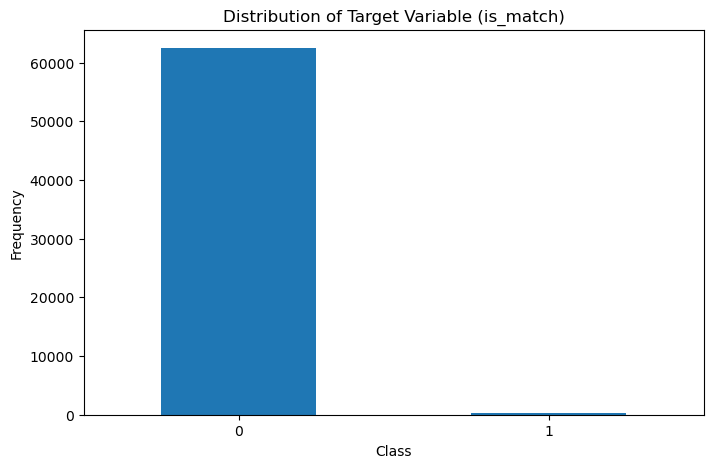

<Figure size 640x480 with 0 Axes>

In [6]:
# plotting the distribution of the target
is_match_counts = df['is_match'].value_counts()

# Plotting
plt.figure(figsize=(8, 5))
is_match_counts.plot(kind='bar')
plt.title('Distribution of Target Variable (is_match)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Word clouds (or tag clouds) visually represent the frequency of words. The size of each word in the word cloud indicates its frequency or importance in the dataset.

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text into one large string
all_text = ' '.join(df['your_text_column'])

# Generate a word cloud image
wordcloud = WordCloud(background_color='white', max_words=200, contour_width=3, contour_color='steelblue').generate(all_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Do not show axes to keep it clean
plt.show()


In [ ]:
# Bar charts or histograms can be used to display the frequency of the top N words or terms in the dataset.

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the text
X = vectorizer.fit_transform(df['your_text_column'])

# Sum word occurrences
word_counts = np.sum(X.toarray(), axis=0)
word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts))

# Convert to DataFrame for easy plotting
word_freq_df = pd.DataFrame(list(word_freq.items()), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the top 20 words
top_words = word_freq_df.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=top_words)
plt.title('Top 20 Words')
plt.show()


In [ ]:
# terms that are particularly important to specific documents using TF-IDF (Term Frequency-Inverse Document Frequency) scores. This can be visualized similarly to term frequencies but represents different insights.
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100)

# Fit and transform the text
X_tfidf = tfidf_vectorizer.fit_transform(df['your_text_column'])

# Get feature names to use as DataFrame column headers
dtm = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [ ]:
# Plotting the distribution of string lengths for the plan names can give you insights into the variance and commonalities in the length of the names, which might affect matching.

df['name_length'] = df['plan_name'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['name_length'], bins=30, kde=True)
plt.title('Distribution of Plan Name Lengths')
plt.xlabel('Length of Plan Name')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Analyzing common prefixes and suffixes in the plan names might help identify patterns or common naming conventions, which can be crucial for string matching.
from collections import Counter

# Example for prefixes
prefixes = df['plan_name'].apply(lambda x: x[:5])  # Adjust the slice as needed
most_common_prefixes = Counter(prefixes).most_common(10)

# Plotting
prefixes_df = pd.DataFrame(most_common_prefixes, columns=['Prefix', 'Frequency'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Prefix', data=prefixes_df)
plt.title('Top 10 Common Prefixes in Plan Names')
plt.show()

In [ ]:
# Assuming you have a way to pair plan names (e.g., via an index or match flag)
# Calculate edit distances for a subset or specific pairs to keep computation reasonable
import Levenshtein as lev

# Example: Calculate edit distance for the first 100 pairs (adjust as needed)
edit_distances = [lev.distance(p1, p2) for p1, p2 in zip(df['plan_name'][:100], df['other_plan_name'][:100])]

plt.figure(figsize=(10, 6))
sns.histplot(edit_distances, bins=20, kde=False)
plt.title('Distribution of Edit Distances Between Plan Name Pairs')
plt.xlabel('Edit Distance')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from sklearn.model_selection import train_test_split
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.metrics import classification_report, accuracy_score
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from keras.layers import Input, Embedding, Flatten, Dense, concatenate
# from keras.models import Model
# from transformers import TFAutoModel, AutoTokenizer
# from sklearn.metrics import confusion_matrix
# from imblearn.over_sampling import SMOTE
# from transformers import BertTokenizer, BertModel
# import seaborn as sns
# from sklearn.linear_model import LogisticRegression
# import torch
# from scipy.spatial.distance import cosine
# import matplotlib.pyplot as plt
# import Levenshtein as lev
# from sklearn.preprocessing import LabelEncoder
# from keras.models import Sequential
# from keras.layers import Dense, Embedding, Flatten
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
# from sklearn.metrics import classification_report, accuracy_score
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)

### SIMPLE NUERAL NETWORK MODEL
* The goal is to take the 4 columns that we use to match on in the UI and to train a neural network on those.
* Starting very naive gives us a baseline to start from
* columns:
  * `census_carrier_name`
  * `plan_admin_name`
  * `carrier_name`
  * `name`

In [ ]:
df_naive = df[['census_carrier_name', 'plan_admin_name', 'carrier_name', 'name']].copy()

# Combine the text columns into one, as we will treat them as one input to the network
df_naive['combined_text'] = df_naive.apply(lambda x: ' '.join(x.astype(str)), axis=1)

# Assuming 'is_match' is the binary target column you want to predict
y = df['is_match'].values  # Or any other column that is the target variable

# Tokenize the text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_naive['combined_text'])
sequences = tokenizer.texts_to_sequences(df_naive['combined_text'])

# Pad sequences to ensure uniform input size
max_sequence_length = max(len(x) for x in sequences)
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the neural network architecture
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=max_sequence_length))
model.add(Flatten())  # Flatten the output of the embedding layer to feed into the dense layer

# Use one neuron with 'sigmoid' activation function for binary classification
model.add(Dense(10, activation='relu'))  # Hidden layer with 10 neurons
model.add(Dense(1, activation='sigmoid'))  # Output layer with one neuron for binary classification

# Compile the model with binary_crossentropy for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
1414/1414 [==============================] - 12s 8ms/step - loss: 0.0365 - accuracy: 0.9944 - val_loss: 0.0284 - val_accuracy: 0.9942
Epoch 2/10
1414/1414 [==============================] - 10s 7ms/step - loss: 0.0226 - accuracy: 0.9947 - val_loss: 0.0268 - val_accuracy: 0.9942
Epoch 3/10
1414/1414 [==============================] - 8s 6ms/step - loss: 0.0199 - accuracy: 0.9947 - val_loss: 0.0272 - val_accuracy: 0.9942
Epoch 4/10
1414/1414 [==============================] - 10s 7ms/step - loss: 0.0184 - accuracy: 0.9947 - val_loss: 0.0288 - val_accuracy: 0.9942
Epoch 5/10
1414/1414 [==============================] - 10s 7ms/step - loss: 0.0176 - accuracy: 0.9947 - val_loss: 0.0308 - val_accuracy: 0.9942
Epoch 6/10
1414/1414 [==============================] - 8s 6ms/step - loss: 0.0165 - accuracy: 0.9947 - val_loss: 0.0298 - val_accuracy: 0.9942
Epoch 7/10
1414/1414 [==============================] - 10s 7ms/step - loss: 0.0157 - accuracy: 0.9947 - val_loss: 0.0323 - val_accu

In [ ]:
# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary output

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])

print(report)

393/393 [==============================] - 1s 2ms/step
Accuracy: 99.50%
              precision    recall  f1-score   support

    Negative       0.99      1.00      1.00     12502
    Positive       0.00      0.00      0.00        63

    accuracy                           0.99     12565
   macro avg       0.50      0.50      0.50     12565
weighted avg       0.99      0.99      0.99     12565



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Results

Accuracy: 99.50%

|            | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| Negative   | 1.00      | 1.00   | 1.00     | 12502   |
| Positive   | 0.50      | 0.11   | 0.18     | 63      |
| **accuracy** |           |        | 0.99     | 12565   |
| **macro avg**  | 0.75      | 0.56   | 0.59     | 12565   |
| **weighted avg** | 0.99      | 0.99   | 0.99     | 12565   |

### Reasoning

Well, that is not very good! Looks like our naive model did quite a bad job with the positive class, which, to be honest is what we really care about. There could be a few reasons WHY this is happening...

* target class imbalance
  * there are significantly more negative targets than there are positive targets. what does this mean? well, we see the model doing great on negative because, well, there are a bunch of those in the training set so it has all possible information. (ex: only 235 positive classes, that is literally 0.005284856974578565 - or .5% of the dataset)
* feature engineering
  * feature engineering is basically about giving the model more data to make predictions with. In other words, the more data we give the model, that can help in uncovering patterns that are not immediately apparent, improving the model's ability to generalize and make predictions.
* model selection
  * In general, picking the right model for the classification task is super important. In this case, we are dealing with a lot of text data, and depending on the feature engieering, some categorical variables. In this way, the choice of model can greatly affect performance, especially in complex tasks like text classification, where the relationships between features (words) and the target variable are not linear or straightforward.

### SIMPLE RANDOM FOREST & XGBOOST MODEL
* The goal is to take the 4 columns that we use to match on in the UI and to train an XGBoost algo on those.
* Starting very naive gives us a baseline to start from
* columns:
  * `census_carrier_name`
  * `plan_admin_name`
  * `carrier_name`
  * `name`

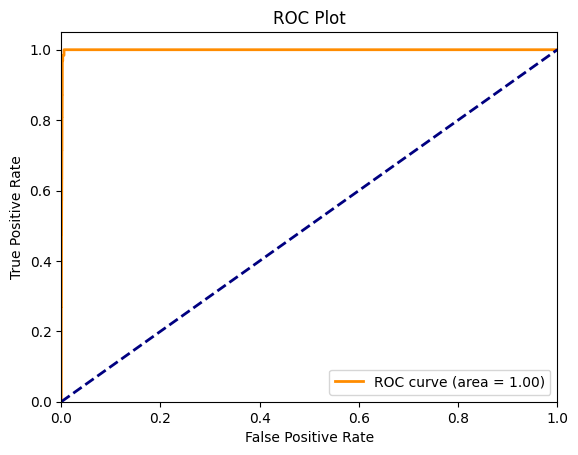

,Accuracy,Precision,Recall,F1 Score,ROC-AUC,Support (Negative),Support (Positive)
Random Forest,0.995782,0.692308,0.285714,0.404494,0.984658,12502,63
XGBoost,0.997294,0.723077,0.746032,0.734375,0.999064,12502,63


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the combined text column to TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df_naive['combined_text'])

# Split the TF-IDF vectors and the target variable into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# RANDOM FOREST
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# XGBOOST
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Define a function to calculate metrics and include support
def calculate_metrics(model, X_test, y_test):
    predictions = model.predict(X_test)
    prob_predictions = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    auc_score = roc_auc_score(y_test, prob_predictions) if prob_predictions is not None else "N/A"

    report = classification_report(y_test, predictions, output_dict=True)

    metrics = {
        "Accuracy": accuracy_score(y_test, predictions),
        "Precision": precision_score(y_test, predictions),
        "Recall": recall_score(y_test, predictions),
        "F1 Score": f1_score(y_test, predictions),
        "ROC-AUC": auc_score,
        "Support (Negative)": report['0']['support'],  # Assuming '0' is the label for the Negative class
        "Support (Positive)": report['1']['support']   # Assuming '1' is the label for the Positive class
    }

    return metrics

def plot_roc_auc(model, X_test, y_test):
    # Predict probabilities for the positive outcome only
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    # Calculate ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Plot')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

# If you want to look at params
# rf_model.get_params()
# xgb_model.get_params()

# Calculate metrics for Random Forest and XGBoost
rf_metrics = calculate_metrics(rf_model, X_test, y_test)
xgb_metrics = calculate_metrics(xgb_model, X_test, y_test)

# Create a DataFrame
metrics_df = pd.DataFrame([rf_metrics, xgb_metrics], index=["Random Forest", "XGBoost"])
xgb_auc = plot_roc_auc(xgb_model, X_test, y_test)
metrics_df

In [52]:
# Split the dataset while retaining indices
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X_tfidf,
    y,
    df_naive.index,  # Assuming df_naive is your DataFrame and you're passing the indices here
    test_size=0.2,
    random_state=42
)

# XGBOOST
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict with XGBoost
predictions = xgb_model.predict(X_test)

# Compare predictions with actual values
incorrect_predictions = predictions != y_test

incorrect_indices = indices_test[incorrect_predictions]

# Assume `predictions`, `y_test`, and `incorrect_indices` are already defined as above

# Since y_test is already a numpy array, directly perform the boolean operations
fp_mask = (predictions == 1) & (y_test == 0)
fn_mask = (predictions == 0) & (y_test == 1)

# However, we need to apply these masks correctly.
# First, we identify all incorrect predictions as a boolean array
incorrect_predictions_mask = predictions != y_test

# Next, we apply this mask to the test indices to get indices of all incorrect predictions
incorrect_indices = indices_test[incorrect_predictions_mask]

# Then, we need to specifically identify FP and FN among these incorrect predictions.
# To do this correctly, we apply the fp_mask and fn_mask to the incorrect_predictions_mask
# Since fp_mask and fn_mask are based on the full set of predictions and actuals,
# we adjust our approach to directly filter indices_test based on fp_mask and fn_mask.
fp_indices = indices_test[fp_mask]
fn_indices = indices_test[fn_mask]

# Use these indices to extract the corresponding rows from df_naive
false_positives_df = df_naive.loc[fp_indices]
false_negatives_df = df_naive.loc[fn_indices]



In [55]:
false_positives_df

,census_carrier_name,plan_admin_name,carrier_name,name,combined_text
23822,California Choice,2023 Kaiser Permanente Silver HMO A,CalChoice,Kaiser Permanente Full Silver HMO E,California Choice 2023 Kaiser Permanente Silve...
26915,California Choice,2023 Kaiser Permanente Gold HMO B,CalChoice,Kaiser Permanente Full Gold HMO C,California Choice 2023 Kaiser Permanente Gold ...
45125,Health Net,2022 WholeCare HMO Network Platinum $20,Health Net,WholeCare HMO Platinum $20 + Chiropractic,Health Net 2022 WholeCare HMO Network Platinum...
54687,Californiachoice,2023 Kaiser Permanente Silver HMO D HSA,CalChoice,Kaiser Permanente Full Silver HMO C,Californiachoice 2023 Kaiser Permanente Silver...
26912,California Choice,2023 Kaiser Permanente Platinum HMO A,CalChoice,Kaiser Permanente Full Platinum HMO B,California Choice 2023 Kaiser Permanente Plati...
41015,California Choice,2022 Kaiser Permanente Gold HMO B,CalChoice,Kaiser Permanente Full Gold HMO E,California Choice 2022 Kaiser Permanente Gold ...
40131,California Choice,2022 Kaiser Permanente Gold HMO B,CalChoice,Kaiser Permanente Full Gold HMO E,California Choice 2022 Kaiser Permanente Gold ...
32739,Blue Shield Of Ca,2023 Platinum Tandem PPO 0/10 OffEx,BlueShield of California,Platinum Tandem PPO 0/10 OffEx,Blue Shield Of Ca 2023 Platinum Tandem PPO 0/1...
58342,Unitedhealthcare,!2023 Gold Signature 35-70/700d CW-YC,UnitedHealthcare,SignatureValue HMO Gold CWX9 /N94S,Unitedhealthcare !2023 Gold Signature 35-70/70...
22779,Anthem Bc Of Ca,Gold Prudent Buyer 30/500/20% 6RG9,Anthem,Anthem Gold PPO 30/750/20%,Anthem Bc Of Ca Gold Prudent Buyer 30/500/20% ...


### RESULT

| Model          | Accuracy | Precision | Recall  | F1 Score | ROC-AUC  | Support (Negative) | Support (Positive) |
|----------------|----------|-----------|---------|----------|----------|--------------------|--------------------|
| Random Forest  | 0.995782 | 0.692308  | 0.285714| 0.404494 | 0.984658 | 12502              | 63                 |
| XGBoost        | 0.997294 | 0.723077  | 0.746032| 0.734375 | 0.999064 | 12502              | 63                 |




### REASONING / NOTES

* well, folks, it looks like our XGBoost model just does pretty dang well right off the bat.
* This is honestly pretty exciting, and it really matches with the magic of the XGBoost models that has kind of become a meme out there.

What are some next steps?
1. I want to first try some re-sampling. In other words, I want to run these models again but with trying to solve the class imbalance.
2. After that, I think I want to try a different vectorizer besides TFDIF. There are probably some better out there, and could be worth an exploration.
2. After seeing what the results of those things are, I think the next place to go is feature engineering. Let's engineer some features for each of the models and see what happens.
3. After that, I think we will have a really good idea of which model will work for us, and then we can go more down the feature engineering path + potentially thinking about hyperparameters.


I would be remiss if I didn't talk about another way to solve this problem. Because we might not get predictable and cleaned data each time, we COULD use an LLM to help us solve the last mile. In other words, if we could return the top 5 most likely plans based on an initial model and then have an LLM - which is great at the non-structured stuff - try and get that last mile of accuracy for us, that could work. The question is... how do we know when to fire off the API request to the LLM. I guess we could have some probability metric where if below a threshold we fire it off? Maybe the context window is just so small that it doesn't even matter from a cost perspective and we could use gpt-3-turbo. I don't really know... but, this is an angle to play with.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid to search
parameter_grid = {
    "max_depth": 8,
    # 'max_depth':range(3,10,2),
    # 'min_child_weight':range(1,6,2)
}

# Set up the grid search with RandomForest
grid_search = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False,eval_metric='logloss'),
                           param_grid=parameter_grid,
                           scoring='f1',
                           verbose=3)

# Perform the search on the training data
grid_search.fit(X_train, y_train)

# Best ROC-AUC score
best_score = grid_search.best_score_
print(f"Best score from Grid Search: {best_score:.4f}")

### PROBLEM 1: OVERSAMPLING

1. First, let's actually plot / prove that we have an oversampling problem. Let's check out the dataframes and get a plot going.
2. Then, we will try to remedy and re-run the XGBoost model.

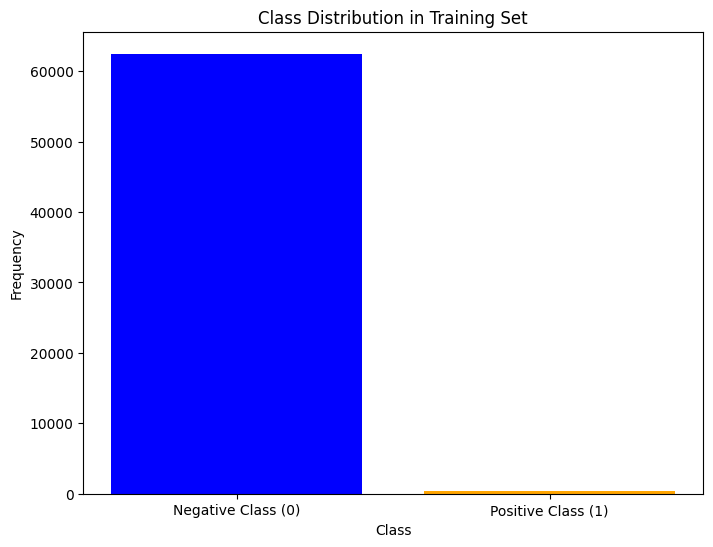

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Count the occurrences of each class in the target variable
class_counts = np.bincount(y_train)
class_labels = ['Negative Class (0)', 'Positive Class (1)']

# Plotting the class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts, color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Set')
plt.show()


In [ ]:
from collections import Counter

# Assuming y is the target variable array from your dataset
counter = Counter(y_train)

# Estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print(f'Estimate: {estimate:.3f}')

Estimate: 185.825


What is the takeaway here?

* basically, we have a massively imbalance dataset. For every one positive target, we have ~185 negative targets. What that means is that the model is going to learn the negative targets really really well, and we need to get it to learn the positive targets better.

What are some solutions?
1. We can just use that estimate from the y_train as the weight.
2. We can use some GridSearch to tune this hyperparameter?

In [ ]:
# 1. we use that estimate variable
xgb_model_balanced = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=estimate)
xgb_model_balanced.fit(X_train, y_train)

# let's see the metrics!
xgb_metrics_estimate = calculate_metrics(xgb_model_balanced, X_test, y_test)
metrics_df = pd.DataFrame([rf_metrics, xgb_metrics, xgb_metrics_estimate], index=["Random Forest", "XGBoost", "XGBoost, Estimate Balanced"])
metrics_df

,Accuracy,Precision,Recall,F1 Score,ROC-AUC,Support (Negative),Support (Positive)
Random Forest,0.995782,0.692308,0.285714,0.404494,0.984658,12502,63
XGBoost,0.997294,0.723077,0.746032,0.734375,0.999064,12502,63
"XGBoost, Estimate Balanced",0.997214,0.645833,0.984127,0.779874,0.999312,12502,63


That is sweet! Look at the improvement in the f1 socre. Our Accuruact wen't down slightly and we see that reflected in the precision. BUT, our f1 score increased.

| Model                     | Accuracy | Precision | Recall  | F1 Score | ROC-AUC  | Support (Negative) | Support (Positive) |
|---------------------------|----------|-----------|---------|----------|----------|--------------------|--------------------|
| Random Forest             | 0.995782 | 0.692308  | 0.285714| 0.404494 | 0.984658 | 12502              | 63                 |
| XGBoost                   | 0.997294 | 0.723077  | 0.746032| 0.734375 | 0.999064 | 12502              | 63                 |
| XGBoost, Estimate Balanced| 0.997214 | 0.645833  | 0.984127| 0.779874 | 0.999312 | 12502              | 63                 |


In [30]:
# For the first weight, lets go from 1 to 300 in steps of 50. Then we can narrow.
# first pass - we got 51 as the best value - list(range(1, 301, 50))
# second pass - we got 41 as the best value - list(range(1, 101, 20))
# third pass - we got 56 as the best value - list(range(21, 66, 5))  - Best score from Grid Search: 0.7750
# last pass - 56 is the best value! - Best score from Grid Search: 0.7750 - Best scale_pos_weight: 56
parameter_grid = {
    "scale_pos_weight": list(range(50, 60, 1))
}

# Set up the grid search with RandomForest
grid_search = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False,eval_metric='logloss'),
                           param_grid=parameter_grid,
                           scoring='f1',
                           verbose=3)

# Perform the search on the training data
grid_search.fit(X_train, y_train)

# Best ROC-AUC score
best_score = grid_search.best_score_
print(f"Best score from Grid Search: {best_score:.4f}")
# Best parameter for scale_pos_weight
best_scale_pos_weight = grid_search.best_params_['scale_pos_weight']
print(f"Best scale_pos_weight: {best_scale_pos_weight}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ...............scale_pos_weight=50;, score=0.750 total time=   6.2s
[CV 2/5] END ...............scale_pos_weight=50;, score=0.796 total time=   4.8s
[CV 3/5] END ...............scale_pos_weight=50;, score=0.703 total time=   3.8s
[CV 4/5] END ...............scale_pos_weight=50;, score=0.782 total time=   3.8s
[CV 5/5] END ...............scale_pos_weight=50;, score=0.804 total time=   5.3s
[CV 1/5] END ...............scale_pos_weight=51;, score=0.752 total time=   3.8s
[CV 2/5] END ...............scale_pos_weight=51;, score=0.789 total time=   3.9s
[CV 3/5] END ...............scale_pos_weight=51;, score=0.729 total time=   5.2s
[CV 4/5] END ...............scale_pos_weight=51;, score=0.789 total time=   3.8s
[CV 5/5] END ...............scale_pos_weight=51;, score=0.814 total time=   3.9s
[CV 1/5] END ...............scale_pos_weight=52;, score=0.768 total time=   5.7s
[CV 2/5] END ...............scale_pos_weight=52;

In [31]:
# 2. now that we have the best score, let's use that!

xgb_model_balanced = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight='56')
xgb_model_balanced.fit(X_train, y_train)

# let's see the metrics!
xgb_metrics_tuned = calculate_metrics(xgb_model_balanced, X_test, y_test)
metrics_df = pd.DataFrame([rf_metrics, xgb_metrics, xgb_metrics_estimate, xgb_metrics_tuned], index=["Random Forest", "XGBoost", "XGBoost, Estimate Balanced", "XGBoost, Tuned"])
metrics_df

,Accuracy,Precision,Recall,F1 Score,ROC-AUC,Support (Negative),Support (Positive)
Random Forest,0.995782,0.692308,0.285714,0.404494,0.984658,12502,63
XGBoost,0.997294,0.723077,0.746032,0.734375,0.999064,12502,63
"XGBoost, Estimate Balanced",0.997214,0.645833,0.984127,0.779874,0.999312,12502,63
"XGBoost, Tuned",0.997453,0.666667,0.984127,0.794872,0.999246,12502,63


There we go! Now we can see the result of the hyperparameter tuning in the table below.

| Model                     | Accuracy | Precision | Recall  | F1 Score | ROC-AUC  | Support (Negative) | Support (Positive) |
|---------------------------|----------|-----------|---------|----------|----------|--------------------|--------------------|
| Random Forest             | 0.995782 | 0.692308  | 0.285714| 0.404494 | 0.984658 | 12502              | 63                 |
| XGBoost                   | 0.997294 | 0.723077  | 0.746032| 0.734375 | 0.999064 | 12502              | 63                 |
| XGBoost, Estimate Balanced| 0.997214 | 0.645833  | 0.984127| 0.779874 | 0.999312 | 12502              | 63                 |
| XGBoost, Tuned            | 0.997453 | 0.666667  | 0.984127| 0.794872 | 0.999246 | 12502              | 63                 |

Okay, now we should inspect which ones the model got wrong, such that we can go in and see if we can build any features that may help.

In [44]:
# Step 1: Make predictions on the test data
predictions = xgb_model_balanced.predict(X_test)

# Step 2: Compare predictions with actual labels
incorrect_indices = [i for i in range(len(y_test)) if predictions[i] != y_test[i]]

# Step 3: Get corresponding rows from DataFrame
incorrect_rows = df.iloc[incorrect_indices]

# Now you can inspect the rows where the model made incorrect predictions
print("Incorrectly predicted rows:")
len(incorrect_rows)


Incorrectly predicted rows:


32

## DATA CLEANING

In [ ]:
### basic processing of df

In [ ]:
# Data Cleaning
df = raw_df[['census_carrier_name','plan_admin_name','carrier_name','name','plan_type','level','hsa_eligible','is_match']].copy()
df.rename(columns={'plan_admin_name':'census_plan_admin_name','carrier_name':'ideon_carrier_name','name':'ideon_name','plan_type':'ideon_plan_type','level':'ideon_plan_level','hsa_eligible':'is_ideon_hsa_hdhp'},inplace=True)

# set up the cleaned column for plan_admin_name and census_carrier_name
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name']

# Remove any capital letter followed by ')' or ':' at the beginning of the string followed by any whitespace - ex: A) or A: or B)
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace('^([A-Z]\\))\\s*|^([A-Z]\\:)\\s*', '', regex=True)

# in a similar way that we want to remove A) or anything, lets also remove numbers 1. or 2.
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace(
    r'\b\d{1,2}\.\s',
    '',
    regex=True
)

# lets remove anything contained in () or [] that is not an issuer_code. In other words, if it does not match [XXXX] or (XXXX), then lets remove the [] or if left
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace(
    r'\(([^)]*)\)|\[([^\]]*)\]|“([^”]*)”|\"([^\"]*)\"',
    lambda x: x.group(0) if re.search(
        r'\([A-Z0-9]{2}-[A-Z0-9]{2}\)|\[A-Z0-9]{2}-[A-Z0-9]{2}\]|\([A-Z0-9]{4}\)|\[A-Z0-9]{4}\]|“[A-Z0-9]{2}-[A-Z0-9]{2}”|"[A-Z0-9]{2}-[A-Z0-9]{2}"|“[A-Z0-9]{4}”|"[A-Z0-9]{4}"',
        x.group(0)
    )
    else '',
    regex=True
)

# remove any weird characters after cleaning up a bunch - :, (, ), *, !, ", '
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace('[!*“”":()]+', '', regex=True)

# remove any occurrence of '(BASE)', '(Base)', or '(base)', as well as any standalone 'BASE', 'Base', or 'base'
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace('\\(BASE\\)|\\(Base\\)|\\(base\\)|\\bBASE\\b|\\bBase\\b|\\bbase\\b', '', regex=True).str.strip()

# remove the YYYY or YY-YY at the beginning of the string with a whitespace after, but be careful of XX-XX and XXXX and other numbers as those are valuable
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace(
    r'^(?:\d{4}|\d{2}-\d{2}|\d{2})\s+',
    '',
    regex=True
)

# remove a plan_id if it is somehow in the string
df['census_plan_admin_name_cleaned'] = df['census_plan_admin_name_cleaned'].str.replace(r'\s*-\s*[0-9A-Z]{14,17}', '', regex=True)

# cleaning the census carrier name
df['census_carrier_name_cleaned'] = df['census_carrier_name']
df['census_carrier_name_cleaned'] = df['census_carrier_name_cleaned'].str.lower().replace({
    '.*anthem.*': 'Anthem',
    '.*choice.*': 'CalChoice',
    '.*medi.*': 'Medi-Excel',
    '.*cigna.*': 'Cigna + Oscar',
    '.*kaiser.*': 'Kaiser Permanente',
    '.*shield.*': 'BlueShield of California',
    '.*sutter.*': 'Sutter Health Plus',
    '.*covered.*': 'CoveredCA',
    '.*united.*': 'UnitedHealthcare',
    '.*uhc.*': 'UnitedHealthcare',
    '.*Western.*': 'Western Health Advantage',
    '.*sharp.*': 'Sharp Health Plan',
    '.*aetna.*': 'Aetna',
    '.*net.*': 'Health Net',
    '.*chinese.*': 'Chinese Community Health Plan'
}, regex=True)
# drop the old columns
df.drop(labels=['census_plan_admin_name','census_carrier_name'],axis=1,inplace=True)

# change ideon_hsa to numeric
df['is_ideon_hsa_hdhp'] = df['is_ideon_hsa_hdhp'].astype(int)
# if hsa is in the census_plan_name, then we indicate
df['is_census_hsa_hdhp'] = df['census_plan_admin_name_cleaned'].apply(lambda x: 'hsa' in x.lower() or 'hdhp' in x.lower()).astype(int)


# get plan level from the census
df['census_plan_level'] = df['census_plan_admin_name_cleaned'].str.extract('(gold|silver|platinum|bronze)', flags=re.IGNORECASE, expand=False)
# normalize 'plan_level'
df['census_plan_level'] = df['census_plan_level'].str.lower()
df['ideon_plan_level'] = df['ideon_plan_level'].replace('expanded_bronze', 'bronze')

# add the levenshtein string distance between plan_admin_name_cleaned and ideon_name
df['plan_name_levenshtein_distance'] = df.apply(lambda row: lev.distance(row['census_plan_admin_name_cleaned'], row['ideon_name']), axis=1)
df['carrier_name_levenshtein_distance'] = df.apply(lambda row: lev.distance(row['census_carrier_name_cleaned'], row['ideon_carrier_name']), axis=1)

# 1. Calculate length of 'census_carrier_name_cleaned' and 'carrier_name'
df['census_carrier_name_length'] = df['census_carrier_name_cleaned'].apply(len)
df['ideon_carrier_name_length'] = df['ideon_carrier_name'].apply(len)

# 2. Create text embeddings for 'census_carrier_name_cleaned' and 'carrier_name'
unique_census_carrier_names = pd.Series(df['census_carrier_name_cleaned'].unique()).dropna()
unique_ideon_carrier_names = pd.Series(df['ideon_carrier_name'].unique()).dropna()
all_unique_carrier_names = pd.concat([unique_census_carrier_names, unique_ideon_carrier_names]).unique()

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(all_unique_carrier_names)

# Transform 'census_carrier_name_cleaned' and 'ideon_carrier_name' to embeddings
df['census_carrier_name_text_embedding'] = list(tfidf_vectorizer.transform(df['census_carrier_name_cleaned']).toarray())
df['ideon_carrier_name_text_embedding'] = list(tfidf_vectorizer.transform(df['ideon_carrier_name']).toarray())

# 3. Calculate cosine similarity between 'census_carrier_name_cleaned' and 'carrier_name' text embeddings
cosine_similarities = cosine_similarity(tfidf_vectorizer.transform(df['census_carrier_name_cleaned']), tfidf_vectorizer.transform(df['ideon_carrier_name']))
df['carrier_name_cosine_similarity'] = [cosine_similarities[i][i] for i in range(len(df))]

# 1. Calculate length of the name columns
df['census_plan_admin_name_cleaned_length'] = df['census_plan_admin_name_cleaned'].apply(len)
df['ideon_name_length'] = df['ideon_name'].apply(len)

# 2. create text embeddings for the name columns
df['plan_names_combined'] = df['census_plan_admin_name_cleaned'] + ' ' + df['ideon_name']
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_vectorizer.fit(df['plan_names_combined'])

# 3. Transform the plan name columns to embeddings
df['census_plan_admin_name_cleaned_embedding'] = list(tfidf_vectorizer.transform(df['census_plan_admin_name_cleaned'].fillna('')).toarray())
df['ideon_name_embedding'] = list(tfidf_vectorizer.transform(df['ideon_name'].fillna('')).toarray())

# 4. Calculate cosine similarity between 'census_plan_level_embedding' and 'ideon_plan_level_embedding'
df['plan_name_cosine_similarity'] = df.apply(lambda row: cosine_similarity([row['census_plan_admin_name_cleaned_embedding']], [row['ideon_name_embedding']])[0][0], axis=1)

,ideon_carrier_name,ideon_name,ideon_plan_type,ideon_plan_level,is_ideon_hsa_hdhp,is_match,census_plan_admin_name_cleaned,census_carrier_name_cleaned,is_census_hsa_hdhp,census_plan_level,plan_name_levenshtein_distance,carrier_name_levenshtein_distance
0,CalChoice,Sharp Health Plan Performance Gold HMO A,HMO,gold,0,1,Sharp Gold HMO A,CalChoice,0,gold,24,0
1,CalChoice,Kaiser Permanente Full Bronze HMO B,HMO,bronze,0,1,Kaiser Permanente Bronze HMO B,CalChoice,0,bronze,5,0
2,CalChoice,Kaiser Permanente Full Silver HMO A,HMO,silver,0,1,Kaiser Permanente Silver HMO A,CalChoice,0,silver,5,0


## MODEL BUILDING

In [ ]:
# Preprocess the text data: Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([df['census_carrier_name_cleaned'], df['ideon_carrier_name'], df['census_plan_admin_name_cleaned'], df['ideon_name']], axis=0))

# Convert text to sequence of integers
census_seq = tokenizer.texts_to_sequences(df['census_carrier_name_cleaned'])
carrier_seq = tokenizer.texts_to_sequences(df['ideon_carrier_name'])
plan_admin_seq = tokenizer.texts_to_sequences(df['census_plan_admin_name_cleaned'])
name_seq = tokenizer.texts_to_sequences(df['ideon_name'])

# Pad sequences to have the same length
max_length = max(max(len(seq) for seq in census_seq), max(len(seq) for seq in carrier_seq), max(len(seq) for seq in plan_admin_seq), max(len(seq) for seq in name_seq))
census_seq_padded = pad_sequences(census_seq, maxlen=max_length)
carrier_seq_padded = pad_sequences(carrier_seq, maxlen=max_length)
plan_admin_seq_padded = pad_sequences(plan_admin_seq, maxlen=max_length)
name_seq_padded = pad_sequences(name_seq, maxlen=max_length)

# Split the dataset into training and testing sets
X = np.concatenate([census_seq_padded, carrier_seq_padded, plan_admin_seq_padded, name_seq_padded], axis=1)
y = df['is_match'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize SMOTE and resample the data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define the DNN model structure (this should be done after SMOTE to get the correct input shape)
input_layer = Input(shape=(X_train_smote.shape[1],))  # Notice we use X_train_smote here
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_train_smote.shape[1])(input_layer)
flatten_layer = Flatten()(embedding_layer)
dense_layer = Dense(64, activation='relu')(flatten_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the data after SMOTE oversampling
model.fit(X_train_smote, y_train_smote, epochs=10, batch_size=32)

# Evaluate the model using the original test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/10
2183/2183 [==============================] - 26s 11ms/step - loss: 0.0888 - accuracy: 0.9684
Epoch 2/10
2183/2183 [==============================] - 24s 11ms/step - loss: 0.0221 - accuracy: 0.9928
Epoch 3/10
2183/2183 [==============================] - 23s 11ms/step - loss: 0.0135 - accuracy: 0.9959
Epoch 4/10
2183/2183 [==============================] - 17s 8ms/step - loss: 0.0101 - accuracy: 0.9966
Epoch 5/10
2183/2183 [==============================] - 13s 6ms/step - loss: 0.0067 - accuracy: 0.9977
Epoch 6/10
2183/2183 [==============================] - 12s 6ms/step - loss: 0.0051 - accuracy: 0.9982
Epoch 7/10
2183/2183 [==============================] - 15s 7ms/step - loss: 0.0041 - accuracy: 0.9986
Epoch 8/10
2183/2183 [==============================] - 15s 7ms/step - loss: 0.0035 - accuracy: 0.9987
Epoch 9/10
2183/2183 [==============================] - 13s 6ms/step - loss: 0.0027 - accuracy: 0.9992
Epoch 10/10
275/275 [==============================] - 1s 2ms/step - l

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# ... [your model training code] ...

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary output

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])

print(report)


275/275 [==============================] - 1s 2ms/step
Accuracy: 99.32%
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      8713
    Positive       0.51      0.49      0.50        61

    accuracy                           0.99      8774
   macro avg       0.75      0.74      0.75      8774
weighted avg       0.99      0.99      0.99      8774



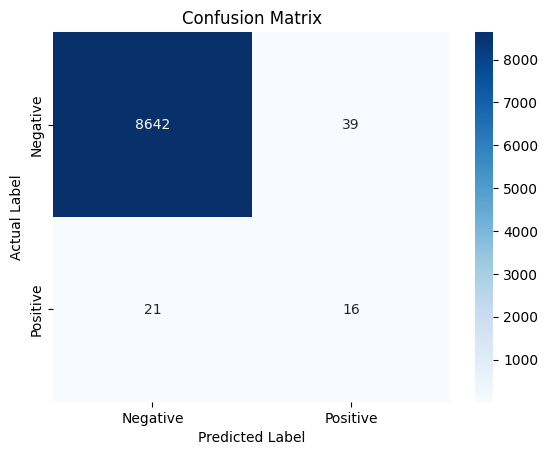

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from transformers import TFAutoModel, AutoTokenizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score